# Desafío Kopuru 🚀
by *Sergio Tejedor Moreno* - [STM](https://www.tejedormoreno.com)

[Enlace al desafío](https://kopuru.com/challenge/modelo-de-prediccion-de-calidad-en-el-vino-para-aidtec-solutions/?tab=tab-link_datos)

A la hora de analizar los datos deben tenerse en cuenta algunos puntos clave:

1. Cada una de las muestras (registros de las muestras) ha sido tomada de una única botella en las mismas condiciones y momento del proceso (tras el embotellado). Por tanto, todas las muestras están sujetas al mismo proceso, ya que se trata de vinos de año.
2. Es importante analizar en profundidad los datos en busca de posibles errores, que puedan afectar al modelo, y gestionarlos de forma correcta para que no afecten. Se recomienda realizar un EDA previo, que se incluirá en el informe.
3. Es importante realizar un análisis de cuáles son las variables más representativas en la decisión de la asignación de la calidad.
4. Es importante establecer cuáles son los valores máximos y mínimos admisibles para cada parámetro.
5. Aplica transformaciones de variables si fuera necesario.
6. Normaliza la información antes de realizar el modelo y toma decisiones que documentarás en el informe final.

**Objetivo**
1. Desarrollar un modelo de clasificación capaz de predecir con los datos de las muestras del 2024 cuál será la calidad de dichas muestras, tomando como referencia datos entre 2019 y 2023.
2. Desarrollar un informe explicativo donde se desarrollen las conclusiones sobre variables que más influyen en los resultados y el por qué, así como el análisis previo de los datos y sus descriptivos.

# Acerca de Este Notebook

- Notebook para cargar el dataset original, verificar la integridad de los datos y realizar correcciones

# Importaciones

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import random
import matplotlib.pyplot as plt
import joblib
import pickle
from textwrap import dedent

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV
                                    )
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import (StandardScaler, FunctionTransformer,
                                    LabelEncoder
                                    )
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer
                            )
from sklearn import tree
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (matthews_corrcoef, precision_score,
                            accuracy_score, recall_score,
                            balanced_accuracy_score, f1_score,
                            make_scorer
                            )

import xgboost as xgb

from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic
from copy import deepcopy

from datetime import datetime
import seaborn as sns

# Rutas

In [ ]:
interim_path = Path(
    dedent(
        "/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/data/interim"
    )
)
raw_path = ruta_dataset = Path(
    dedent(
        "/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/data/raw"
    )
)

raw_data_file = "calidad_vino_AT-_train.csv"

# Comprobación integridad de los datos

In [ ]:
df_raw = pd.read_csv(ruta_dataset / raw_data_file, index_col=0)
df_raw
df = df_raw.copy()
df

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,densidad,pH,sulfatos,alcohol,color,year,calidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,tinto,2021,7
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,0.99182,3.34,0.46,11.4,blanco,2021,5
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,0.99810,3.14,0.56,9.7,tinto,2019,5
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,0.99521,3.34,0.52,10.2,blanco,2021,6
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.1,blanco,2023,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,blanco,2021,5
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,tinto,2022,5
5195,12.0,0.37,0.76,4.2,0.066,7.0,38.0,10.00400,3.22,0.60,13.0,tinto,2022,7


## Información general

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
acidez fija,5198.0,7.208580,1.293990,3.90000,6.4000,7.00000,7.70000,15.900
acidez volatil,5198.0,0.339555,0.164113,0.08000,0.2300,0.29000,0.40000,1.580
acido citrico,5198.0,0.318825,0.145903,0.00000,0.2500,0.31000,0.39000,1.660
azucar residual,5198.0,5.432205,4.744450,0.60000,1.8000,3.00000,8.10000,65.800
cloruros,5198.0,0.055988,0.034539,0.00900,0.0380,0.04700,0.06500,0.610
dioxido de azufre libre,5198.0,30.466718,17.817899,1.00000,17.0000,29.00000,41.00000,289.000
dioxido de azufre total,5198.0,115.570796,56.553849,6.00000,77.0000,118.00000,155.75000,440.000
densidad,5198.0,1.725172,7.711798,0.98711,0.9924,0.99488,0.99692,103.898
pH,5198.0,3.218765,0.161618,2.72000,3.1100,3.21000,3.32000,4.010
sulfatos,5198.0,0.531951,0.149878,0.22000,0.4300,0.51000,0.60000,2.000


- A simple vista, la variable **densidad** vemos que tiene valores anormales. Una densidad de un vino no puede ser muy superior a 1 y sin embargo hay valores máximos de 103.
- Llama la atención que la variable **alcohol** no aparezca
- Cabe preguntarse si el mínimo de 0 de la variable ácido cítrico es posible

- Exploraremos estas tres variables ya que es posible que se trate de errores en los datos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5198 entries, 0 to 5197
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   acidez fija              5198 non-null   float64
 1   acidez volatil           5198 non-null   float64
 2   acido citrico            5198 non-null   float64
 3   azucar residual          5198 non-null   float64
 4   cloruros                 5198 non-null   float64
 5   dioxido de azufre libre  5198 non-null   float64
 6   dioxido de azufre total  5198 non-null   float64
 7   densidad                 5198 non-null   float64
 8   pH                       5198 non-null   float64
 9   sulfatos                 5198 non-null   float64
 10  alcohol                  5198 non-null   object 
 11  color                    5198 non-null   object 
 12  year                     5198 non-null   int64  
 13  calidad                  5198 non-null   int64  
dtypes: float64(10), int64(2)

## Valores nulos

In [ ]:
df.isna().sum(axis=0)

acidez fija                0
acidez volatil             0
acido citrico              0
azucar residual            0
cloruros                   0
dioxido de azufre libre    0
dioxido de azufre total    0
densidad                   0
pH                         0
sulfatos                   0
alcohol                    0
color                      0
year                       0
calidad                    0
dtype: int64

- No hay valores nulos, por lo tanto no habrá que realizar operaciones de imputación

## Valores duplicados

In [ ]:
df.duplicated().sum()

171

- Existen 171 valores duplicados que procederemos a eliminar para minimizar el ruido cuando entrenemos los modelos

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

- Hemos comprobado que se han eliminado correctamente los duplicados

In [ ]:
df

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,densidad,pH,sulfatos,alcohol,color,year,calidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,tinto,2021,7
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,0.99182,3.34,0.46,11.4,blanco,2021,5
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,0.99810,3.14,0.56,9.7,tinto,2019,5
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,0.99521,3.34,0.52,10.2,blanco,2021,6
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.1,blanco,2023,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,blanco,2021,5
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,tinto,2022,5
5195,12.0,0.37,0.76,4.2,0.066,7.0,38.0,10.00400,3.22,0.60,13.0,tinto,2022,7


## Tipos de las variables

In [ ]:
df.dtypes

acidez fija                float64
acidez volatil             float64
acido citrico              float64
azucar residual            float64
cloruros                   float64
dioxido de azufre libre    float64
dioxido de azufre total    float64
densidad                   float64
pH                         float64
sulfatos                   float64
alcohol                     object
color                       object
year                         int64
calidad                      int64
dtype: object

- La columna **alcohol** tiene un tipo que no corresponde con sus valores
- La columna **color** es categorica
- La columna **year** es categórica también

- El tipo 'object' de la variables **alcohol** no corresponde con lo que se espera de dicha variable ya que según la documentación, es:
> la Proporción de alcohol en el vino

- Y una proporción es un valor numérico.

## Variable **Alcohol**

In [ ]:
df['alcohol'].value_counts()

9.5                    294
9.4                    263
9.2                    211
10.0                   184
10.5                   175
                      ... 
12.15                    1
131.333.333.333.333      1
117.333.333.333.333      1
11.35                    1
113.666.666.666.667      1
Name: alcohol, Length: 106, dtype: int64

- Vemos que hay valores que no tienen sentido
- La hipótesis más probable es que haya sido un error en la posición de la coma.

- Comprobamos cuántos valores son

In [ ]:
df_alcohol_malos = df[df['alcohol'].apply(len) > 5].copy()
df_alcohol_malos.shape[0]

33

In [ ]:
df_alcohol_malos.head(5)

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,densidad,pH,sulfatos,alcohol,color,year,calidad
muestra_id,,,,,,,,,,,,,,
21,6.5,0.13,0.27,2.60,0.035,32.0,76.0,0.99140,3.21,0.76,113.333.333.333.333,blanco,2020,6
76,6.1,0.44,0.28,4.25,0.032,43.0,132.0,0.99160,3.26,0.47,112.666.666.666.667,blanco,2019,7
254,6.6,0.34,0.40,8.10,0.046,68.0,170.0,0.99494,3.15,0.50,953.333.333.333.333,blanco,2020,6
459,8.4,0.27,0.30,2.20,0.037,36.0,129.0,0.99085,2.89,0.30,114.666.666.666.667,blanco,2020,6
518,6.4,0.29,0.21,9.65,0.041,36.0,119.0,0.99334,2.99,0.34,109.333.333.333.333,blanco,2019,6


- Parece que ha sido algún error con el formato decimal.
- Una posible solución podría ser quitar los puntos, truncar a partir del cuarto número y poner un punto en el segundo dígito.
- otra opción podría ser borrar estos registros ya que no suponen gran cantidad

Crearemos 2 datasets uno corrigiendo los datos como si de un error de coma se tratase y otro eliminando los registros

#### Corrección de Variable **Alcohol**

- Creamos una función auxiliar para corregir los valores erróneos que acepte una variable (que será la variable alcohol) y devuelve dicha variable con los datos corregidos.

In [ ]:
def filtrar_alcohol_malos(feature: np.ndarray) -> np.ndarray:
    """Devuelve los valores de alcohol potencialmente erróneos"""
    return feature[feature.apply(len) > 5]

def corregir_valores_alcohol_array(feature: pd.DataFrame) -> pd.DataFrame:
    # Copiamos la feature
    feature_ = feature.copy()
    # Filtramos los valores erroneos
    feature_malos = filtrar_alcohol_malos(feature_)
    # Quitamos los puntos
    if feature_malos.dtype != 'O':
        raise ValueError('La feature debe ser de tipo object')
    feature_limpio = feature_malos.str.replace('.', '', regex=True)
    # Si empieza por 8 o 9 agregamos un 0 delante
    feature_limpio[feature_limpio.str.startswith(('8', '9'))] = \
        '0' + feature_limpio
    # Añadimos el punto desde la posición 2
    feature_limpio = feature_limpio.str.slice(0, 2) + '.' + \
        feature_limpio.str.slice(1, 4)
    # Modificamos en el dataset completo
    feature_[feature_malos.index] = feature_limpio
    return feature_.astype('float64') # Devolvemos el tipo

- Creamos el dataset df_alcohol_corregido en el que corregiremos los valores erróneos de la variable alcohol

In [ ]:
# Podemos utilizar esta función en una pipeline más adelante
df_alcohol_corregido = df.copy()
corregir_alcohol = FunctionTransformer(corregir_valores_alcohol_array)
alcohol_corregido: pd.Series = corregir_alcohol.transform(
    df_alcohol_corregido.alcohol)
df_alcohol_corregido.alcohol = alcohol_corregido
df_alcohol_corregido

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,densidad,pH,sulfatos,alcohol,color,year,calidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,tinto,2021,7
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,0.99182,3.34,0.46,11.4,blanco,2021,5
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,0.99810,3.14,0.56,9.7,tinto,2019,5
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,0.99521,3.34,0.52,10.2,blanco,2021,6
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.1,blanco,2023,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,blanco,2021,5
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,tinto,2022,5
5195,12.0,0.37,0.76,4.2,0.066,7.0,38.0,10.00400,3.22,0.60,13.0,tinto,2022,7


- Realizamos comprobaciones adicionales

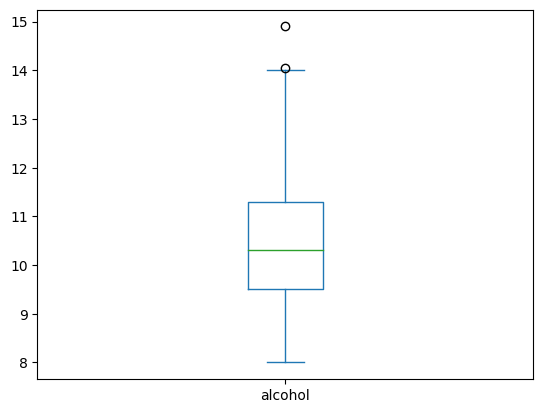

In [ ]:
df_alcohol_corregido.alcohol.plot(kind='box');

In [ ]:
df_alcohol_corregido.dtypes

acidez fija                float64
acidez volatil             float64
acido citrico              float64
azucar residual            float64
cloruros                   float64
dioxido de azufre libre    float64
dioxido de azufre total    float64
densidad                   float64
pH                         float64
sulfatos                   float64
alcohol                    float64
color                       object
year                         int64
calidad                      int64
dtype: object

In [ ]:
df_alcohol_corregido['alcohol'].describe()

count    5027.000000
mean       10.499196
std         1.182948
min         8.000000
25%         9.500000
50%        10.300000
75%        11.300000
max        14.900000
Name: alcohol, dtype: float64

- Ahora los valores parecen mucho más coherentes

- Vamos a guardar el dataset reflejando todas las operaciones realizadas

In [ ]:
df_name = "calidad_vino_AT-_train-drop_duplicated_corregir_alcohol.csv"
df_alcohol_corregido.to_csv(interim_path / df_name)

### Eliminación de la variable alcohol

- Vamos a proceder a crear otro dataset pero esta vez eliminando las variables erróneas de alcohol

- Crearemos una función que realice dicha operación

In [ ]:
def eliminar_valores_alcohol(df: pd.DataFrame) -> pd.DataFrame:
    # Copiamos la feature
    df_ = df.copy()
    # Filtramos los valores erroneos
    alcohol_malos_idx = filtrar_alcohol_malos(df_.alcohol).index
    # Quitamos los puntos dichos indices
    df_ = df_.drop(index=alcohol_malos_idx)
    # Cambiamos el tipo al tipo correcto
    df_.alcohol = df_.alcohol.astype('float64')
    return df_

In [ ]:
# Podemos utilizar esta función en una pipeline más adelante
df_alcohol_eliminados = df.copy()
eliminar_alcohol = FunctionTransformer(eliminar_valores_alcohol)
df_alcohol_eliminados: pd.DataFrame = eliminar_alcohol.transform(df_alcohol_eliminados)
df_alcohol_eliminados

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,densidad,pH,sulfatos,alcohol,color,year,calidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,tinto,2021,7
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,0.99182,3.34,0.46,11.4,blanco,2021,5
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,0.99810,3.14,0.56,9.7,tinto,2019,5
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,0.99521,3.34,0.52,10.2,blanco,2021,6
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.1,blanco,2023,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,blanco,2021,5
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,tinto,2022,5
5195,12.0,0.37,0.76,4.2,0.066,7.0,38.0,10.00400,3.22,0.60,13.0,tinto,2022,7


- Realizamos alguna comprobación

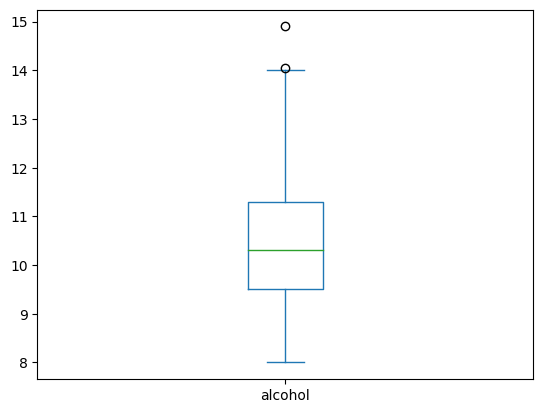

In [ ]:
df_alcohol_eliminados.alcohol.plot(kind='box');

In [ ]:
df_alcohol_eliminados['alcohol'].describe()

count    4994.000000
mean       10.497930
std         1.184672
min         8.000000
25%         9.500000
50%        10.300000
75%        11.300000
max        14.900000
Name: alcohol, dtype: float64

- Parece que todo es coherente

- Guardamos el dataset

In [ ]:
df_name = "calidad_vino_AT-_train-drop_duplicates-eliminar_alcohol.csv"
df_alcohol_eliminados.to_csv(interim_path / df_name)

## Variable Densidad

- Otro error que salta a la vista es el de la variable Densidad. Densidades mayores de 1 no son normales

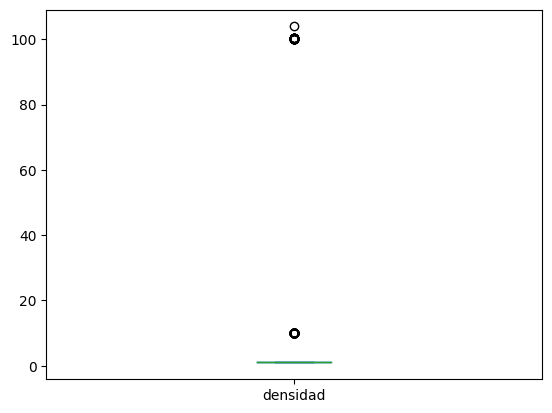

In [ ]:
df.densidad.plot(kind='box');

- La densidad del vino puede ir entre 0,990 g/ml y 1,090 g/ml. Pero en ningún caso tiene sentido que aumente por encima de 10.
- Vamos a explorar estos valores extremos más en detalle

In [ ]:
df_densidad_malos = df[df['densidad'] > 2].copy()
df_densidad_malos.densidad

muestra_id
17       10.001
88       10.003
91       10.001
103      10.011
186      10.004
         ...   
5011     10.002
5073     10.004
5084    100.315
5159     10.032
5195     10.004
Name: densidad, Length: 105, dtype: float64

- Parece que al igual que pasaba con el caso del alcohol, ha fallado la posición de la coma
- Podemos realizar dos operaciones:
    1. Corregir los valores y poner la coma en su sitio para que las densidades vuelvan a tener valores en torno a 1
    2. Eliminar dicho registros

- Guardaremos ambos datasets

- Partimos el dataset de valores de alcohol corregidos y creamos la primera combinación
- Escribimos una función auxiliar que haga la tarea

#### Corrección de Variable Densidad

In [ ]:
def filtrar_densidad_malos(feature: pd.Series) -> pd.Series:
    """Devuelve los valores de densidad erróneos"""
    return feature[feature > 2]

def corregir_valores_densidad_array(feature: pd.Series) -> pd.Series:
    # Copiamos la feature
    feature_ = feature.copy()
    # Filtramos los valores erroneos
    feature_malos = filtrar_densidad_malos(feature_)
    # Creamos función que procese los valores malos
    def dividir_por_diez(valor: float) -> float:
        while valor >= 10:  # Mientras el valor sea igual o mayor a 10,
            valor /= 10  # dividir entre 10.
        return valor

    feature_corregidos = feature_malos.apply(dividir_por_diez)

    # Sustituimos los corregidos
    feature_[feature_malos.index] = feature_corregidos

    return feature_

Podemos utilizar esta función en una Pipeline más adelante

In [ ]:
df_densidad_corregido = df.copy()
corregir_densidad = FunctionTransformer(corregir_valores_densidad_array)
densidad_corregido: pd.Series = corregir_densidad.transform(
    df_densidad_corregido.densidad)
df_densidad_corregido.densidad = densidad_corregido
df_densidad_corregido

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,densidad,pH,sulfatos,alcohol,color,year,calidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,tinto,2021,7
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,0.99182,3.34,0.46,11.4,blanco,2021,5
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,0.99810,3.14,0.56,9.7,tinto,2019,5
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,0.99521,3.34,0.52,10.2,blanco,2021,6
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.1,blanco,2023,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,blanco,2021,5
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,tinto,2022,5
5195,12.0,0.37,0.76,4.2,0.066,7.0,38.0,1.00040,3.22,0.60,13.0,tinto,2022,7


Realizamos algunas comprobaciones adicionales

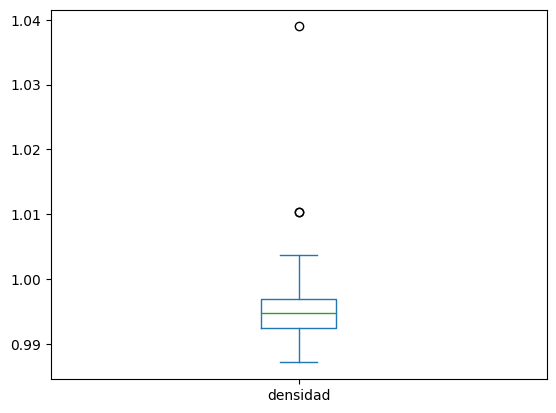

In [ ]:
df_densidad_corregido.densidad.plot(kind='box');

In [ ]:
df_densidad_corregido.densidad.describe()

count    5027.000000
mean        0.994669
std         0.002992
min         0.987110
25%         0.992370
50%         0.994800
75%         0.996900
max         1.038980
Name: densidad, dtype: float64

Parece que todos los valores de densidad son coherentes

Guardamos el dataset

In [ ]:
df_name = "calidad_vino_AT-_train-drop_duplicates-corregir_densidad.csv"
df_densidad_corregido.to_csv(interim_path / df_name)

#### Eliminación de la variable densidad

Al igual que hicimos con la variable alcohol, vamos a eliminar los valores erróneos de densidad, en lugar de corregirlos
- Para ello crearemos una función auxiliar

In [ ]:
def eliminar_valores_densidad(df: pd.DataFrame) -> pd.DataFrame:
    # Copiamos la feature
    df_ = df.copy()
    # Filtramos los valores erroneos
    densidad_malos_idx = filtrar_densidad_malos(df_.densidad).index
    print(f'Se van a eliminar {len(densidad_malos_idx)} índices')
    # Quitamos los valores de dichos indices
    df_ = df_.drop(index=densidad_malos_idx)
    return df_

In [ ]:
# Podemos utilizar esta función en una pipeline más adelante
df_densidad_eliminados = df.copy()
eliminar_densidad = FunctionTransformer(eliminar_valores_densidad)
df_densidad_eliminados: pd.DataFrame = eliminar_densidad.transform(df_densidad_eliminados)
df_densidad_eliminados

Se van a eliminar 105 índices


,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,densidad,pH,sulfatos,alcohol,color,year,calidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,tinto,2021,7
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,0.99182,3.34,0.46,11.4,blanco,2021,5
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,0.99810,3.14,0.56,9.7,tinto,2019,5
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,0.99521,3.34,0.52,10.2,blanco,2021,6
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.1,blanco,2023,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,6.6,0.22,0.53,15.1,0.052,22.0,136.0,0.99860,2.94,0.35,9.4,blanco,2021,5
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,blanco,2021,5
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,tinto,2022,5


Realizamos algunas comprobaciones complementarias

<Axes: >

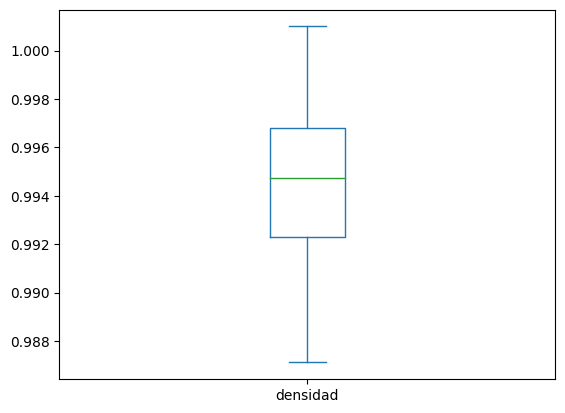

In [ ]:
df_densidad_eliminados.densidad.plot(kind='box');

In [ ]:
df_densidad_eliminados.densidad.describe()

count    4922.000000
mean        0.994525
std         0.002796
min         0.987110
25%         0.992300
50%         0.994740
75%         0.996800
max         1.001000
Name: densidad, dtype: float64

Vemos que el tipo es correcto y los valores coherentes

- Guardamos el dataset

In [ ]:
df_name = "calidad_vino_AT-_train-drop_duplicates-eliminar_densidad.csv"
df_densidad_eliminados.to_csv(interim_path / df_name)

- Estas dos variables eran en las que a priori había datos erróneos, las demás parecen coherentes en sus valores. No obstante las observaremos con algo más de detalle.

## Variable **Ácido Cítrico**

In [ ]:
df['acido citrico'].describe()

count    5198.000000
mean        0.318825
std         0.145903
min         0.000000
25%         0.250000
50%         0.310000
75%         0.390000
max         1.660000
Name: acido citrico, dtype: float64

- Podríamos preguntarnos si los valores de 0 en el ácido cítrico son esperables o de pueden tratar de errores o valores perdidos

Una búsqueda en internet nos arroja esta información:
> El ácido cítrico en vinos puede variar en concentración dependiendo de varios factores, incluyendo el tipo de uva, las condiciones del suelo, el clima, y las prácticas de vinificación. Aunque no es uno de los ácidos primarios en la mayoría de los vinos, que son el tartárico y el málico, su presencia contribuye a la complejidad y al perfil de sabor general del vino. En el contexto de la vinificación, el ácido cítrico a menudo se añade durante el proceso de vinificación para ajustar la acidez y mejorar la estabilidad y el sabor del vino.

> El ácido cítrico, específicamente, a menudo se añade a los vinos como un ajuste para la acidez o para influir en la estabilidad y el sabor. La decisión de añadir ácido cítrico, y por lo tanto su presencia o ausencia (incluyendo valores de 0), está más ligada a las decisiones enológicas y las necesidades específicas del vino que se está produciendo, más que al tipo de uva per se.

- Podríamos preguntarnos si hay correlación entre el color (tipo de uva) y el ácido cítrico

In [ ]:
df_sin_acido_citrico = df[df['acido citrico'] == 0]

In [ ]:
df_sin_acido_citrico.color.value_counts(normalize=True)

color
tinto     0.869919
blanco    0.130081
Name: proportion, dtype: float64

- Vemos una prepoderancia clara de uva negra en los valores de ácido cítrico de 0

- Verificamos si el año ha podido influir o tiene una relación con las variables que tienen acido cítrico 0

In [ ]:
df_sin_acido_citrico.year.value_counts()

year
2023    31
2019    25
2022    23
2020    22
2021    22
Name: count, dtype: int64

Las variables de ácido cítrico parecen igualmente repartidas por año

- Podemos pues considerar que los 123 valores con valores nulos de ácido cítrico son registros correctos

## Variable **color**

Variable categórica que deberá ser binarizada posteriormente

In [ ]:
df.color.describe()

count       5027
unique         2
top       blanco
freq        3778
Name: color, dtype: object

In [ ]:
df.color.value_counts()

blanco    3778
tinto     1249
Name: color, dtype: int64

- Los valores parecen correctos

## Variable **year**

Variable categórica que deberá Onehotearse más adelante

Realizamos el mismo proceso de transformación a categórica

In [ ]:
df.year.value_counts(normalize=True) * 100

2021    21.006565
2023    20.111398
2019    19.972150
2020    19.773225
2022    19.136662
Name: year, dtype: float64

- Vemos que los valores son correctos y la repartición de los años es equitativa

## Variable **Calidad**

In [ ]:
df.calidad.value_counts(normalize=True).sort_index()

3    0.004376
4    0.033817
5    0.328824
6    0.442411
7    0.160334
8    0.029242
9    0.000995
Name: calidad, dtype: float64

- Hay una preponderancia clara de las calidades 5 y 6. Entre las 2 se llevan el 76 % de las calidades
- Habrá que tenerlo en cuenta para las métricas más adelante

- Con esto concluye la primera inspección de los datos en la que se han corregido y generado 4 datasets:
    1. Quitar duplicados, corregir valores de alcohol
    2. Quitar duplicados, eliminar valores erróneos de alcohol
    3. Quitar duplicados, corregir valores de densidad
    4. Quitar duplicados, eliminar valores de densidad

- Vamos a crear 2 nuevos datasets fusionando aquellos en los que se eliminan los índices erróneos y aquellos otros en los que se han corregido los índices erróneos

## Fusionado Dataset con correcciones

In [ ]:
df_alcohol_corregido_path = Path('/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/AidTec Solutions Wine Quality/data/interim/calidad_vino_AT-_train-drop_duplicates-corregir_alcohol.csv')
df_densidad_corregido_path = Path('/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/AidTec Solutions Wine Quality/data/interim/calidad_vino_AT-_train-drop_duplicates-corregir_densidad.csv')

In [ ]:
df_al = pd.read_csv(df_alcohol_corregido_path, index_col=0)
df_den = pd.read_csv(df_densidad_corregido_path, index_col=0)

Juntamos ambos datasets conservando las columnas corregidas de cada uno

In [ ]:
df_al.drop(columns=['densidad'], inplace=True)
df_al_den = df_al.join(df_den[['densidad']], how='outer')
df_al_den

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,pH,sulfatos,alcohol,color,year,calidad,densidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,3.28,0.73,11.8,tinto,2021,7,0.99720
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,3.34,0.46,11.4,blanco,2021,5,0.99182
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,3.14,0.56,9.7,tinto,2019,5,0.99810
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,3.34,0.52,10.2,blanco,2021,6,0.99521
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,3.05,0.56,11.1,blanco,2023,6,0.99146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,3.19,0.48,9.2,blanco,2021,5,0.99290
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,3.24,0.53,10.3,tinto,2022,5,0.99682
5195,12.0,0.37,0.76,4.2,0.066,7.0,38.0,3.22,0.60,13.0,tinto,2022,7,1.00040


In [ ]:
df_al_den.alcohol.describe()

count    5027.000000
mean       10.499196
std         1.182948
min         8.000000
25%         9.500000
50%        10.300000
75%        11.300000
max        14.900000
Name: alcohol, dtype: float64

In [ ]:
df_al_den.densidad.describe()

count    5027.000000
mean        0.994669
std         0.002992
min         0.987110
25%         0.992370
50%         0.994800
75%         0.996900
max         1.038980
Name: densidad, dtype: float64

Guardamos el dataset, que será el punto de partida para los análisis posteriores

In [ ]:
df_name = "calidad_vino_AT-_train-drop_duplicates-corregir_alcogol-corregir_densidad.csv"
df_al_den.to_csv(interim_path / df_name)

## Fusionado Dataset con eliminaciones

In [ ]:
df_alcohol_eliminado_path = Path('/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/AidTec Solutions Wine Quality/data/interim/calidad_vino_AT-_train-drop_duplicates-eliminar_alcohol.csv')
df_densidad_eliminado_path = Path('/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/AidTec Solutions Wine Quality/data/interim/calidad_vino_AT-_train-drop_duplicates-eliminar_densidad.csv')

In [ ]:
df_al = pd.read_csv(df_alcohol_eliminado_path, index_col=0)
df_den = pd.read_csv(df_densidad_eliminado_path, index_col=0)

Juntamos ambos datasets eliminando las filas con valores que no coincidan (inner)

In [ ]:
df_fusionado = pd.merge(df_al, df_den, on='muestra_id', how='inner')
columnas_eliminar = [col + '_y' for col in df.columns]
df_fusionado = df_fusionado.drop(columns=columnas_eliminar)
df_fusionado.columns = df.columns
df_fusionado

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,densidad,pH,sulfatos,alcohol,color,year,calidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,tinto,2021,7
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,0.99182,3.34,0.46,11.4,blanco,2021,5
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,0.99810,3.14,0.56,9.7,tinto,2019,5
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,0.99521,3.34,0.52,10.2,blanco,2021,6
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.1,blanco,2023,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,6.6,0.22,0.53,15.1,0.052,22.0,136.0,0.99860,2.94,0.35,9.4,blanco,2021,5
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,0.99290,3.19,0.48,9.2,blanco,2021,5
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,tinto,2022,5


In [ ]:
df_fusionado.isna().sum()

acidez fija                0
acidez volatil             0
acido citrico              0
azucar residual            0
cloruros                   0
dioxido de azufre libre    0
dioxido de azufre total    0
densidad                   0
pH                         0
sulfatos                   0
alcohol                    0
color                      0
year                       0
calidad                    0
dtype: int64

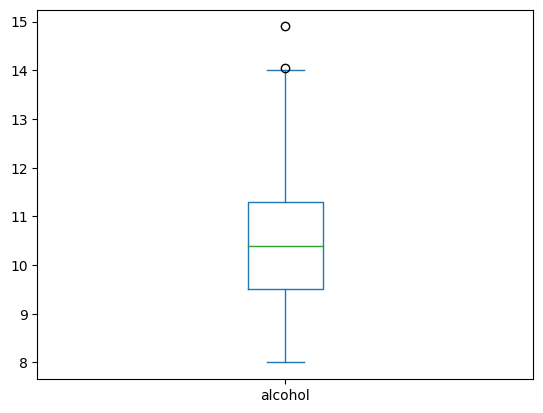

In [ ]:
df_fusionado.alcohol.plot(kind='box');

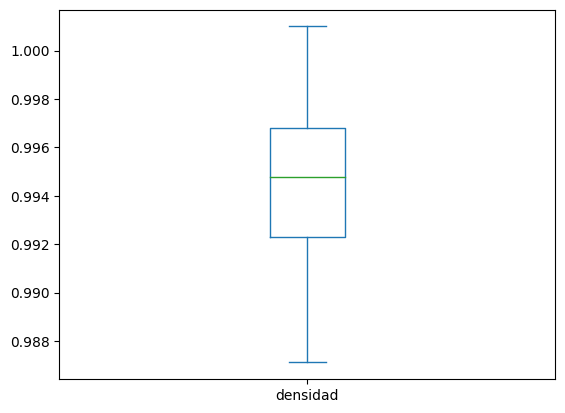

In [ ]:
df_fusionado.densidad.plot(kind='box');

Guardamos el dataset con los valores eliminados

In [ ]:
df_name = "calidad_vino_AT-_train-drop_duplicates-eliminar_alcogol-eliminar_densidad.csv"
df_fusionado.to_csv(interim_path / df_name)